### General helper functions

In [61]:
## Standard imports
import numpy as np
import random
import matplotlib.pyplot as plt
import skimage.io, scipy.ndimage
import skimage.morphology, skimage.transform

%matplotlib inline

def show_image(img, title="untitled", cmap="gray", **kwargs):
    plt.figure()
    plt.imshow(img, cmap=cmap, interpolation="nearest", **kwargs)
    plt.axis("off")
    plt.title(title)

def reshape(img):
    return np.reshape(img, (image_width, image_height))

def plot_results(input_imgs, output_imgs, labels, cmap='gist_yarg'):
    fig = plt.figure(figsize=(15, 15))
    rn = 8
    for i in range(1, 6):
        print(labels[i+rn])
        ax = fig.add_subplot(1, 5, i)
        plt.imshow(reshape(input_imgs[i+rn]), cmap=cmap)
        ax.axis('off')

    for i in range(1, 6):
        ax = fig.add_subplot(2, 5, i)
        plt.imshow(reshape(output_imgs[i+rn]), cmap=cmap)
        ax.axis('off') 

## functions taken from CVMA course!
def apply_color(img, fn):
    return np.dstack((fn(img[:,:,0]),fn(img[:,:,1]),fn(img[:,:,2])))

# adapted for 16-bit image
def load_and_normalise(fname):
    return skimage.io.imread(fname) / 65536.0

def load_gray(f):
    return skimage.color.rgb2gray(load_and_normalise(f))

### Read and resize dataset

#### Processing helper functions

In [25]:
def even_round(num):
    return round(num/2.)*2

def dataset_split(dataset, labels, test_size=0.2):
    test_size = even_round(len(dataset)*test_size)
    x_train, x_test = dataset[:-test_size], dataset[-test_size:]
    y_train, y_test = labels[:-test_size], labels[-test_size:]
    return x_train, x_test, y_train, y_test

def filenames_to_labels(filenames, folder):
    # 0: unstimulated
    # 1: OVA
    # 2: ConA
    # 3: unknown (human error)
    labels = []
    for file in filenames:
        file = file.split("(")[0].lstrip(folder)
        label = int("".join(_ for _ in file if _ in "123456789"))
        if label in [1, 2, 3, 4, 5, 6, 7, 8, 12, 24]:
            label = 0
        elif label in [9, 10, 11, 13, 14, 15, 23]:
            label = 1
        elif label in [16, 17, 18, 19, 20, 21, 22]:
            label = 2
        else:
            label = 3
        labels.append(label)
    return labels

In [62]:
# resize images
# read images into arrays
# read resized images back into folder for future use

import os
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.util import crop

folder = '/Users/Leonore/Documents/Workspace/l4proj/data/raw'
image_width = 200
image_height = 200

filenames = [os.path.join(folder, f)for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
filenames = sorted(filenames)[1:] # remove .DS_STORE

dataset = np.ndarray(shape=(len(filenames), image_width, image_height), dtype=np.float32)

i = 0
for file in filenames:
    try:
        image = load_and_normalise(file)
        to_crop = (image.shape[0]-image_width)/2
        image_resized = crop(image, (to_crop, to_crop))
        dataset[i] = image_resized
        #imsave("/Users/Leonore/Documents/Workspace/l4proj/data/processed" + file.lstrip(folder), image_resized)
    except Exception as e:
        print(e)
        print("{} is causing issues".format(file))
    i += 1

labels = filenames_to_labels(filenames, folder)

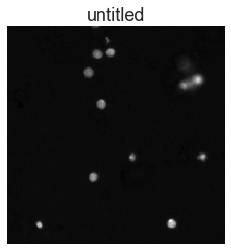

In [63]:
show_image(dataset[56])

In [72]:
from PIL import Image
formatted = (dataset[56] * 65535 / np.max(dataset[56])).astype('uint16')
img = Image.fromarray(formatted)
img.save("/Users/Leonore/Documents/Workspace/l4proj/data/processed/" + "your_file.tif")

In [73]:
a = load_and_normalise("/Users/Leonore/Documents/Workspace/l4proj/data/processed/" + "your_file.tif")

In [74]:
a

array([[ 9810, 10026,  9810, ...,  9724,  9638,  9466],
       [ 9509, 10241,  9896, ...,  9509,  9380,  9165],
       [ 9638,  9638,  9983, ...,  9208,  9122,  9638],
       ...,
       [ 9767, 10628, 10284, ...,  9509,  9767,  9810],
       [10241,  9896,  9638, ...,  9983,  9638,  9638],
       [ 9724, 10241, 10671, ..., 10026,  9509,  9983]], dtype=uint16)

In [75]:
a/655356

array([[0.01496896, 0.01529856, 0.01496896, ..., 0.01483774, 0.01470651,
        0.01444406],
       [0.01450967, 0.01562662, 0.01510019, ..., 0.01450967, 0.01431283,
        0.01398477],
       [0.01470651, 0.01470651, 0.01523294, ..., 0.01405038, 0.01391915,
        0.01470651],
       ...,
       [0.01490335, 0.01621714, 0.01569223, ..., 0.01450967, 0.01490335,
        0.01496896],
       [0.01562662, 0.01510019, 0.01470651, ..., 0.01523294, 0.01470651,
        0.01470651],
       [0.01483774, 0.01562662, 0.01628275, ..., 0.01529856, 0.01450967,
        0.01523294]])

In [49]:
from skimage.io import imsave
imsave("/Users/Leonore/Documents/Workspace/l4proj/data/processed/" + filenames[3].lstrip(folder), dataset[3])

/Users/Leonore/Documents/Workspace/venv/ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: /Users/Leonore/Documents/Workspace/l4proj/data/processed/A - 11(fld 1 wv TexasRed - TexasRed).tif is a low contrast image
  


In [27]:
# x_train and x_test need to be kept in same order 
# as we need to do pairwise overlap calculations
x_train, x_test, y_train, y_test = dataset_split(dataset, labels, test_size=0.2)

x_train = np.reshape(x_train, (len(x_train), image_width, image_height, 1))
x_test = np.reshape(x_test, (len(x_test), image_width, image_height, 1))

### Build autoencoder model

In [28]:
# build autoencoder for dataset

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(image_width, image_height, 1))  # adapt this if using `channels_first` image data format

x =  Conv2D(64, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)
#encoded = x

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x =  Conv2D(64, (5, 5), activation='relu', padding='same')(x)
# this will help going back the original image dimensions
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), padding='same')(x)

In [ ]:
encoder.summary()

In [29]:
model = Model(input_img, decoded)
encoder = Model(input_img, encoded)

In [ ]:
model.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
model.fit(x_train, x_train, epochs=50, batch_size=50)

In [30]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = model.predict(x_test)

1
0
0
1
1


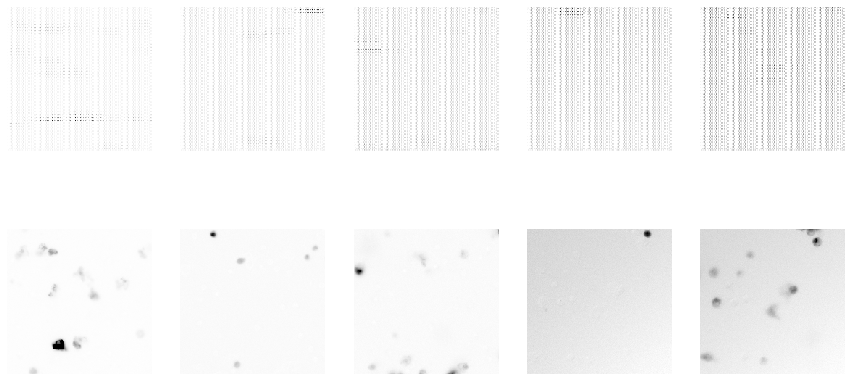

In [31]:
plot_results(x_test, encoded_imgs, y_test, cmap="gist_yarg")

1
0
0
1
1


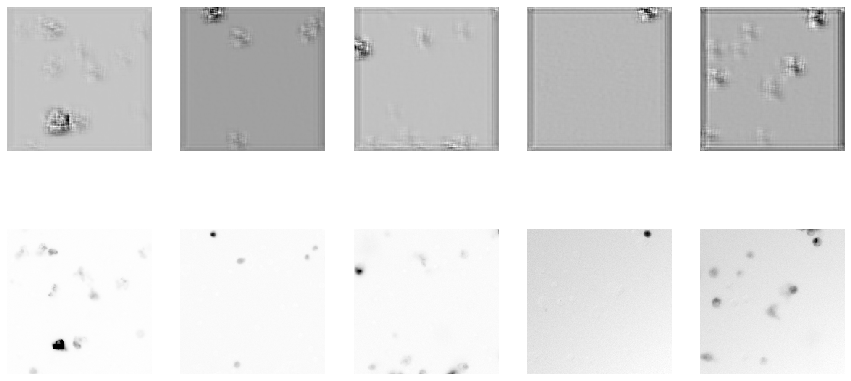

In [32]:
plot_results(x_test, decoded_imgs, y_test)

### Calculate overlap between images

In [34]:
# calculate overlap between t-cell and dendritic cell
# according to stimulation
# incl. compute labels for each 

def calculate_overlap(imgs, labels):
    idx, y = 0, 0
    overlaps = np.ndarray(shape=(len(imgs)//2, image_width*image_height), dtype=np.float32)
    overlap_labels = []
    while idx < len(imgs)-1:
        tcell = imgs[idx]
        dcell = imgs[idx+1]
        #o = reshape(np.abs(dcell-tcell))
        o = np.abs(dcell-tcell)
        overlaps[y] = o
        overlap_labels.append(labels[y])
        idx += 2
        y += 1
    return overlaps, overlap_labels

x_overlap, y_overlap = calculate_overlap(encoded_imgs, y_test)
#overlap, _ = calculate_overlap(x_test, y_test)

1
0
0
1
1


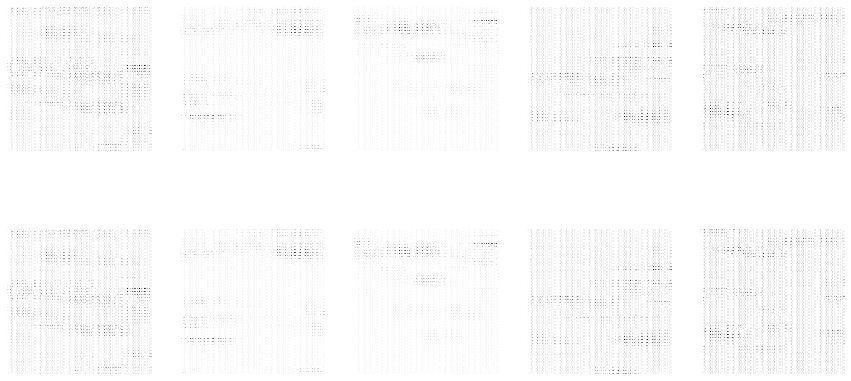

In [35]:
plot_results(x_overlap, x_overlap, y_test)

### Clustering algorithm

In [ ]:
x_overlap.shape

In [ ]:
encoded_imgs.shape

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca_result = pca.fit_transform(x_overlap)

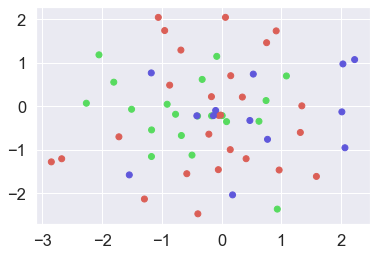

In [44]:
# https://www.datacamp.com/community/tutorials/introduction-t-sne
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=10, early_exaggeration=12.0, learning_rate=20)
clusters = tsne.fit_transform(pca_result)

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# choose a colour palette with seaborn
num_classes = len(np.unique(y_overlap))
palette = np.array(sns.color_palette("hls", num_classes))

plt.scatter(clusters[:,0], clusters[:,1], c=palette[y_overlap])

### View filters; code snippets

In [ ]:
d1 = np.reshape(decoded_imgs[0], (image_width, image_height))
before = np.reshape(sample, (image_width, image_height))filters, biases = model.layers[1].get_weights()

In [ ]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:,:,:,i]
    #plt.figure()
    #plt.imshow(f[:,:,0], cmap='gray')
    ix+=1

In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

In [ ]:
# redefine model to output right after the first hidden layer
feature_model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [ ]:
sample = np.expand_dims(x_train[44], axis=0)

In [ ]:
feature_maps = feature_model.predict(sample)

In [ ]:
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        plt.figure()
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1

In [ ]:
# plot the feature maps for each layer 
encoding_idx = [1, 3, 5]
outputs = [model.layers[i].output for i in encoding_idx]
feature_model = Model(inputs=model.inputs, output=outputs)
feature_maps = feature_model.predict(sample)
square = 4
for fmap in feature_maps:
    ix = 1
    for _ in range(square):
        for _ in range(square):
            plt.figure()
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
        ix += 1
    plt.show()

In [ ]:
# plot the decompressed images from each layer
decoding_idx = [7, 9, 11]
outputs = [model.layers[i].output for i in decoding_idx]
decode_model = Model(inputs=model.inputs, outputs=outputs)
output_maps = decode_model.predict(sample)
square = 8
for out in output_maps:
    ix = 1
    for _ in range(square):
        plt.figure()
        plt.imshow(out[0, :, :, ix-1], cmap='gray')
        ix+=1